# Notebook to make Figure 2

In [ ]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import importlib
import json
import h5ify
import os
import tqdm
import imageio

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
style.use('../utils/plotting.mplstyle')
from matplotlib.lines import Line2D

import seaborn as sns
cp = sns.color_palette('muted')
cp2 = sns.color_palette('pastel')

import sys
sys.path.append('../utils')
import plotting_functions as pf

# where data is saved
data_dir = '../data/different_SNRs/'

### Setup

Load data

In [1]:
# Load in posteriors
posteriors_dict = h5ify.load(data_dir+'posteriors_different_SNRs.h5'),

# Load in the prior
prior_dict = h5ify.load(data_dir+'../real_and_maxL_GW190521/prior.h5')

# Load in the signals' parameters
injected_params_dict = h5ify.load(data_dir+'parameters_different_SNRs.h5')

# Load in the signals' strain
injection_strain_dict = h5ify.load(data_dir+'waveforms_different_SNRs.h5')

Set up plotting aesthetics

In [2]:
# which SNRs to plot 
SNRs_to_plot = ['SNR 15', 'SNR 20', 'SNR 30', 'SNR 40']

# colors associated with each SNR
colors = [cp[2], cp[8] , cp2[3], cp[3]]

# which cutoff times to plot
cutoff_cycles = ['-3.0', '-1.0', '0.0', '0.5']

# mass of the injections
M_inj = injected_params_dict['SNR 15']['mtotal']

### Make Figure

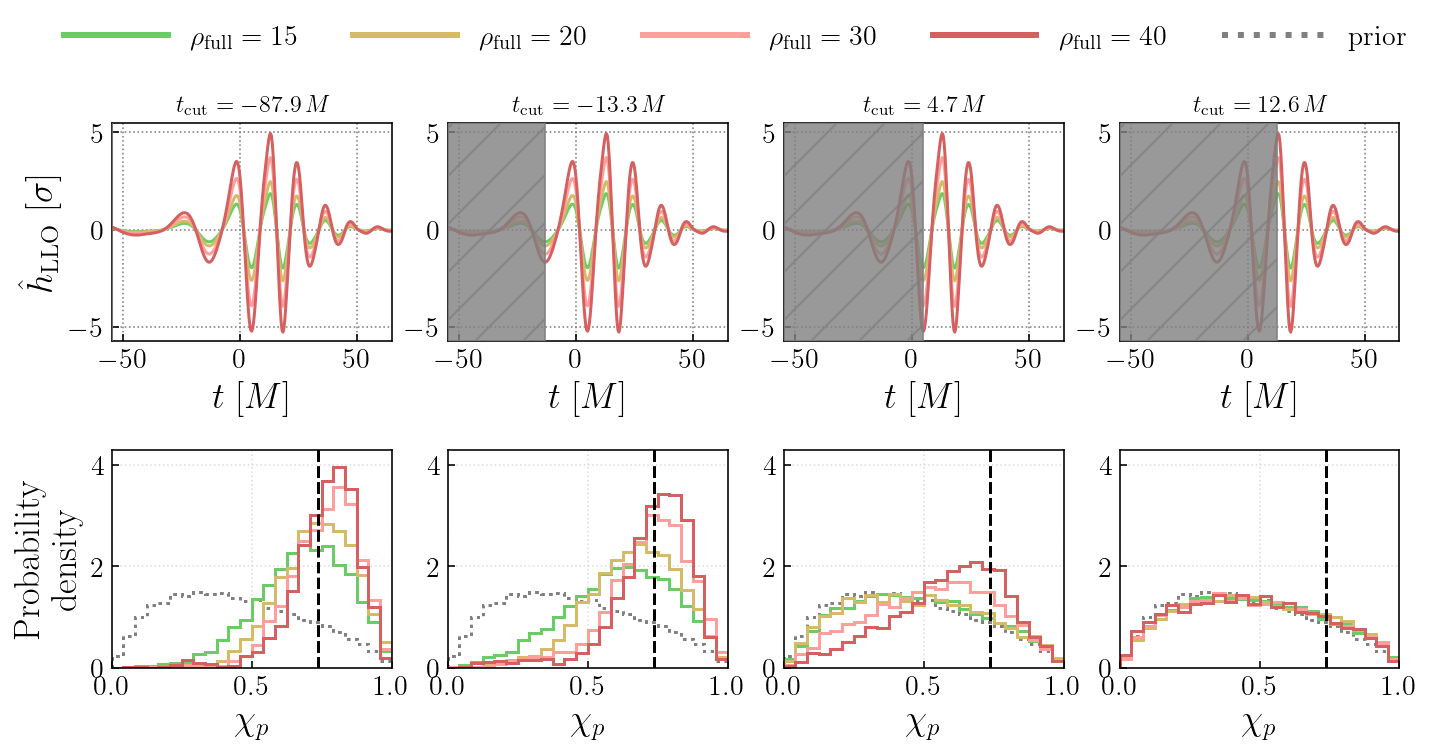

In [3]:
importlib.reload(pf)

# make figure
fig = plt.figure(figsize=(pf.DEFAULT_FIG_WIDTH, pf.DEFAULT_FIG_WIDTH/2.3))
axes1, axes2 = pf.custom_axes(2, [4, 4])

handles= []

# cycle through cutoff times and SNRs
for i, cycle in enumerate(cutoff_cycles): 
    for n, SNR in enumerate(SNRs_to_plot): 
                
        color = colors[n]
        
        # plot injections
        ax = axes1[i]
        
        injection = injection_strain_dict[SNR]
        
        ifo = 'L1'
        ref_time_ifo = injected_params_dict[SNR][f'{ifo}_time']
        times = injection['time_dict'][ifo] - ref_time_ifo
        times_M = pf.transform_s_to_M(times, M_inj)
        strain_wh = injection['strain_wh'][ifo]
        
        # get time from cycle
        t = round(pf.get_tcut_from_Ncycles(injection['strain'][ifo], times, float(cycle)), 3)
        
        ax.plot(times_M, strain_wh, c=color)
        pf.set_limits_and_labels_of_whitened_wf_plot(ax, unit='M')        
        ax.set_ylim(-5.7,5.5)
        
        t_M = np.round(pf.transform_s_to_M(t, M_inj),1)
        ax.set_title(fr'$t_{{\rm cut}} = {t_M}\,M$')
        
        if i!=0:
            ax.set_ylabel('')
        
        # plot chi-p posteriors
        ax = axes2[i]
    
        posterior = posteriors_dict[0][SNR][f'post {cycle}cycles']
        
        p = 'chi_p'
        bins = np.linspace(pf.xlims[p][0],  pf.xlims[p][-1], 25)
        hist_kws = dict(histtype='step', density=True, bins=bins, lw=1.5, color=color)
        prior_hist_kws = dict(histtype='step', density=True, bins=bins, lw=1.5, 
                              color='gray', ls=':', zorder=0)
        
        ymax = 4.3
        pf.plot_posterior(ax, posterior[p], pf.xlims[p], ymax, pf.params[p], ylabel='Probability\ndensity', **hist_kws)
        pf.plot_posterior(ax, prior_dict[p], pf.xlims[p], ymax, pf.params[p], ylabel='Probability\ndensity', **prior_hist_kws)
        
        true_value = injected_params_dict[SNR][p]
        ax.axvline(true_value, color='k', lw=1.5, ls='--')
        
        if i!=0: 
            ax.set_ylabel('')
        else: 
            # concatenate for legend
            handles.append(Line2D([], [], color = colors[n], label = fr'$\rho_{{\rm full}} = {SNR[-2:]}$'))
        
    # shade out the excluded data
    ax = axes1[i]
    ax.fill_betweenx(ax.get_ylim(), ax.get_xlim()[0], float(t_M), color='gray', alpha=0.8, zorder=3, hatch='/')

# adjust spacing
plt.subplots_adjust(hspace=0.5) 

# add legend
handles.append(Line2D([], [], color='gray', ls=':', label = 'prior')) 
pf.add_legend(fig, handle_lw=3, handles=handles, ncol=len(handles), loc='upper center', 
              bbox_to_anchor=(0.5, 1.05), handlelength=3.7)

plt.savefig('figure_02.png', dpi=300, bbox_inches='tight')
plt.show()